*******************************************************
# Deep Learning | Tripadvisor hotel reviews dataset
********************************************************

## Importing Libraries

In [1]:
%%time

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf
from keras.utils import np_utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

Wall time: 3.53 s


********************************
# Part - 1
********************************

In [2]:
%%time
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

Wall time: 145 ms


In [3]:
%%time
df.head()

Wall time: 997 µs


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Data Visualization

In [4]:
%%time
# Print two records from each class
df.sort_values(['Rating']).groupby('Rating').head(2)

Wall time: 8.97 ms


,Review,Rating
11578,not good checked asked room track said dollars...,1
17628,terrible service ignorant staff reading great ...,1
20295,westin vs expedia booked expedia people reques...,2
2785,not repeat customer seeing positive reviews si...,2
8816,american hotel amsterdam based reviews trip ad...,3
14032,"good hotel, stayed mid-march 2004 pretty pleas...",3
18653,pretty good price husband stayed majestic 7 da...,4
18969,great style service stayed granados 83 october...,4
17134,hotel hotel seen like it.stayed hotel 7th feb ...,5
17132,"fabulous vacation, loved bahia principe, staff...",5


Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.
Print the shapes of train and test data.

Wall time: 173 ms


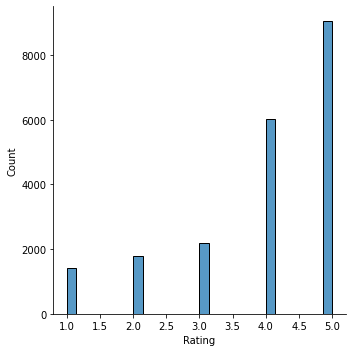

In [5]:
%%time
sns.displot(x="Rating", data=df)

## Data Pre-processing

In [6]:
%%time
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
embeded_reviews = embed(df['Review'])

Wall time: 1.57 s


In [7]:
%%time
embeded_reviews = embeded_reviews.numpy()
embeded_reviews

Wall time: 5.52 ms


array([[ 0.20585984,  0.18637095, -0.15752402, ..., -0.0944639 ,
         0.5119964 , -0.01507805],
       [ 0.24491759,  0.6142323 , -0.15370035, ..., -0.30324394,
         0.6917187 , -0.1235842 ],
       [ 0.02124509,  0.52650404, -0.2957632 , ..., -0.38237888,
         0.7460834 , -0.1734074 ],
       ...,
       [ 0.06914312,  0.29563522, -0.17144734, ..., -0.5006316 ,
         0.4049592 , -0.11970636],
       [ 0.4242196 ,  1.065797  , -0.12848337, ..., -0.24944922,
         0.85995525,  0.14251286],
       [ 0.16960736,  0.37283498, -0.05605149, ..., -0.07607685,
         0.53097796,  0.16431849]], dtype=float32)

In [8]:
%%time
encoder = LabelEncoder()
encoder.fit(df['Rating'])
encoded_Rating = encoder.transform(df['Rating'])
dummy_Rating = np_utils.to_categorical(encoded_Rating)

Wall time: 1.96 ms


In [9]:
%%time
# Label encoding inverse to check whether the encoding happened correctly or not.
df['Rating_trans'] = np.argmax(dummy_Rating, axis=-1)

Wall time: 998 µs


In [10]:
%%time
dummy_Rating

Wall time: 0 ns


array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [11]:
%%time
X_train, X_test, y_train, y_test = train_test_split(embeded_reviews, dummy_Rating, test_size=0.3, random_state=42)

inverse_transformed_y_test = np.argmax(y_test, axis=-1)

Wall time: 8.98 ms


In [12]:
%%time
# summarize history for loss
def plot_model_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# summarize history for accuracy
def plot_model_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Added custom callback function for the keras which we are implement so that we can trace the total training time elaspsed.
class TimingCallback(keras.callbacks.Callback):
  def __init__(self):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs=None):
    self.starttime=time()
  def on_epoch_end(self, epoch, logs=None):
    self.logs.append(time()-self.starttime)
    
def calculate_total_correct_incorrect_prediction(confusion_matrix):
    array = []
    for i in range(0, confusion_matrix.shape[1]):
        temp = []
        temp2 = 0
        temp.append(i + 1)
        for j in range(0, confusion_matrix[i].shape[0]):
            if i == j:
                temp.append(confusion_matrix[i][j])
            else:
                temp2 += confusion_matrix[i][j]
        total = temp[1] + temp2
        temp.append(str(round((temp[1] / total) * 100, 2)) + '%') 
        temp.append(temp2)
        temp.append(str(round((temp2 / total) * 100, 2)) + '%') 
        array.append(temp)
    return pd.DataFrame(array, columns = ['Rating', 'Correct', 'Correct_Perc','Incorrect', 'InCorrect_Perc'])

Wall time: 998 µs


In [13]:
%%time
q1_model_comparision = []

Wall time: 0 ns


## Deep learning models

### Model 1
#### 1. Model Building
The model is build with sequential model having 3 hidden layers. Having 128 nodes in first hidden layer, 64 nodes in second hidden layer and 64 in the third layer. We noticed that the model was training well with the less number of the nodes since we have a good amount of data. Hence with many Experimental configuration, this was one which was giving the top results.

In [14]:
%%time
model4 = keras.Sequential(name = 'Model-4')
model4.add(layers.InputLayer(input_shape=(128,)))

model4.add(layers.Dense(128, activation='relu', kernel_regularizer='l2'))
model4.add(layers.Dropout(0.4))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))

model4.add(layers.Dense(5, activation='softmax'))

model4.summary()

Model: "Model-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
Wall time: 48.9 ms


#### 2. Model Compilation

In [15]:
%%time
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

Wall time: 16 ms


#### 3. Model Training

In [16]:
%%time
callback4 = TimingCallback()
history4 = model4.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback4])

Epoch 1/150
57/57 [==============================] - 1s 4ms/step - loss: 3.2464 - accuracy: 0.4424 - val_loss: 2.3668 - val_accuracy: 0.4330
Epoch 2/150
57/57 [==============================] - 0s 2ms/step - loss: 1.9432 - accuracy: 0.4770 - val_loss: 1.5893 - val_accuracy: 0.4943
Epoch 3/150
57/57 [==============================] - 0s 2ms/step - loss: 1.4594 - accuracy: 0.5094 - val_loss: 1.3185 - val_accuracy: 0.5111
Epoch 4/150
57/57 [==============================] - 0s 2ms/step - loss: 1.2792 - accuracy: 0.5253 - val_loss: 1.2355 - val_accuracy: 0.5088
Epoch 5/150
57/57 [==============================] - 0s 2ms/step - loss: 1.2104 - accuracy: 0.5294 - val_loss: 1.1671 - val_accuracy: 0.5330
Epoch 6/150
57/57 [==============================] - 0s 2ms/step - loss: 1.1739 - accuracy: 0.5325 - val_loss: 1.1541 - val_accuracy: 0.5228
Epoch 7/150
57/57 [==============================] - 0s 2ms/step - loss: 1.1648 - accuracy: 0.5294 - val_loss: 1.1645 - val_accuracy: 0.5348
Epoch 8/150
5

Epoch 59/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0583 - accuracy: 0.5632 - val_loss: 1.0405 - val_accuracy: 0.5672
Epoch 60/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0601 - accuracy: 0.5604 - val_loss: 1.0444 - val_accuracy: 0.5751
Epoch 61/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0693 - accuracy: 0.5621 - val_loss: 1.0389 - val_accuracy: 0.5725
Epoch 62/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0605 - accuracy: 0.5641 - val_loss: 1.0503 - val_accuracy: 0.5626
Epoch 63/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0651 - accuracy: 0.5595 - val_loss: 1.0437 - val_accuracy: 0.5626
Epoch 64/150
57/57 [==============================] - 0s 4ms/step - loss: 1.0595 - accuracy: 0.5650 - val_loss: 1.0357 - val_accuracy: 0.5712
Epoch 65/150
57/57 [==============================] - 0s 4ms/step - loss: 1.0592 - accuracy: 0.5658 - val_loss: 1.0463 - val_accuracy: 0.5764
Epoch 

57/57 [==============================] - 0s 2ms/step - loss: 1.0469 - accuracy: 0.5659 - val_loss: 1.0255 - val_accuracy: 0.5711
Epoch 117/150
57/57 [==============================] - 0s 3ms/step - loss: 1.0445 - accuracy: 0.5697 - val_loss: 1.0237 - val_accuracy: 0.5787
Epoch 118/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0499 - accuracy: 0.5672 - val_loss: 1.0905 - val_accuracy: 0.5379
Epoch 119/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0571 - accuracy: 0.5670 - val_loss: 1.0265 - val_accuracy: 0.5721
Epoch 120/150
57/57 [==============================] - 0s 2ms/step - loss: 1.0504 - accuracy: 0.5687 - val_loss: 1.0468 - val_accuracy: 0.5597
Epoch 121/150
57/57 [==============================] - 0s 3ms/step - loss: 1.0487 - accuracy: 0.5669 - val_loss: 1.0250 - val_accuracy: 0.5768
Epoch 122/150
57/57 [==============================] - 0s 3ms/step - loss: 1.0442 - accuracy: 0.5690 - val_loss: 1.0274 - val_accuracy: 0.5779
Epoch 123/150

<-------------Model Loss Graph------------->


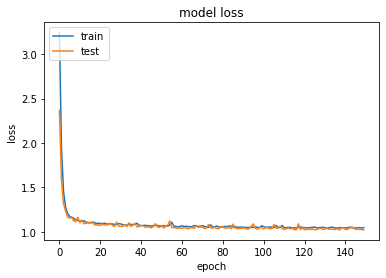

<-------------Model Accuracy Graph------------->


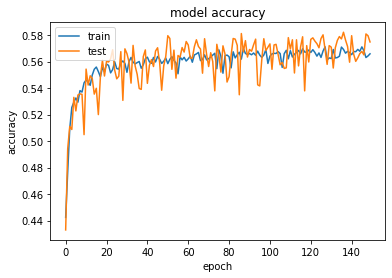

Wall time: 269 ms


In [17]:
%%time
print('<-------------Model Loss Graph------------->')
plot_model_loss(history4)

print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history4)

In [18]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback4.logs)))

Total time taken in training the model: 23.41 seconds
Wall time: 998 µs


#### 4. Model Evaluation

193/193 [==============================] - 0s 665us/step - loss: 1.0240 - accuracy: 0.5748

Test accuracy = 0.5748210549354553 
loss - 1.0240286588668823


Classification Report
               precision    recall  f1-score   support

           0       0.58      0.70      0.63       432
           1       0.37      0.40      0.38       523
           2       0.42      0.07      0.11       645
           3       0.48      0.39      0.43      1887
           4       0.65      0.84      0.74      2661

    accuracy                           0.57      6148
   macro avg       0.50      0.48      0.46      6148
weighted avg       0.55      0.57      0.54      6148


Confusion Matrix Display


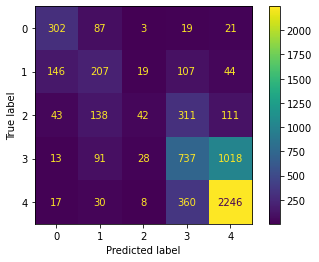

Wall time: 540 ms


In [19]:
%%time
loss4, acc4 = model4.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc4, loss4))
y_pred4 = np.argmax(model4.predict(X_test), axis=-1)
cm4 = classification_report(inverse_transformed_y_test, y_pred4)
print('\nClassification Report\n', cm4)
print('=====================================================\n')
confusion_matrix4 = confusion_matrix(inverse_transformed_y_test, y_pred4)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix4, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [20]:
%%time
q1_model_comparision.append(['Model-1', loss4, acc4])

Wall time: 0 ns


In [21]:
%%time
calculate_total_correct_incorrect_prediction(confusion_matrix4)

Wall time: 2.99 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,302,69.91%,130,30.09%
1,2,207,39.58%,316,60.42%
2,3,42,6.51%,603,93.49%
3,4,737,39.06%,1150,60.94%
4,5,2246,84.4%,415,15.6%


In [22]:
%%time
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")

Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
Wall time: 0 ns


In [23]:
#==============================================================================
# Two most incorrectly classified records for each class in the test dataset.
#==============================================================================

# for i in range(1,6):  
#     count =0
#     for index, input, prediction, label in zip(enumerate(X_test), X_test, y_pred4, inverse_transformed_y_test):
#         print(index, input, prediction, label)
#         if prediction != label and count<10:
#             print(', has been classified as', prediction, 'and should be', label) 
#             count=count+1

## Hyperparameter tuning
### Model 2 (Without Regularization)
#### 1. Model Building
The model is build with sequential model having 3 hidden layers. Having 128 nodes in first hidden layer, 64 nodes in second hidden layer and 64 in the third layer. We noticed that the model was training well with the less number of the nodes since we have a good amount of data. Hence with many Experimental configuration, this was one which was giving the top results.

In [24]:
%%time
model5 = keras.Sequential(name = 'Model-5')
model5.add(layers.InputLayer(input_shape=(128,)))

model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(0.1))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(64, activation='relu'))

model5.add(layers.Dense(5, activation='softmax'))

model5.summary()

Model: "Model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
Wall time: 29.9 ms


#### 2. Model Compilation

In [25]:
%%time
model5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

Wall time: 4.99 ms


#### 3. Model Training

In [26]:
%%time
callback5 = TimingCallback()
history5 = model5.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback5])

Epoch 1/150
57/57 [==============================] - 1s 5ms/step - loss: 1.2511 - accuracy: 0.4588 - val_loss: 1.0581 - val_accuracy: 0.5023
Epoch 2/150
57/57 [==============================] - 0s 3ms/step - loss: 1.0356 - accuracy: 0.5389 - val_loss: 0.9948 - val_accuracy: 0.5534
Epoch 3/150
57/57 [==============================] - 0s 4ms/step - loss: 0.9925 - accuracy: 0.5574 - val_loss: 0.9986 - val_accuracy: 0.5384
Epoch 4/150
57/57 [==============================] - 0s 4ms/step - loss: 0.9807 - accuracy: 0.5647 - val_loss: 0.9712 - val_accuracy: 0.5608
Epoch 5/150
57/57 [==============================] - 0s 4ms/step - loss: 0.9631 - accuracy: 0.5707 - val_loss: 0.9561 - val_accuracy: 0.5649
Epoch 6/150
57/57 [==============================] - 0s 4ms/step - loss: 0.9553 - accuracy: 0.5763 - val_loss: 0.9516 - val_accuracy: 0.5701
Epoch 7/150
57/57 [==============================] - 0s 3ms/step - loss: 0.9445 - accuracy: 0.5800 - val_loss: 0.9617 - val_accuracy: 0.5623
Epoch 8/150
5

57/57 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.7356 - val_loss: 1.1880 - val_accuracy: 0.5379
Epoch 59/150
57/57 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.7409 - val_loss: 1.2081 - val_accuracy: 0.5369
Epoch 60/150
57/57 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.7332 - val_loss: 1.2146 - val_accuracy: 0.5333
Epoch 61/150
57/57 [==============================] - 0s 2ms/step - loss: 0.6423 - accuracy: 0.7253 - val_loss: 1.2390 - val_accuracy: 0.5187
Epoch 62/150
57/57 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0.7422 - val_loss: 1.2326 - val_accuracy: 0.5376
Epoch 63/150
57/57 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.7495 - val_loss: 1.2354 - val_accuracy: 0.5338
Epoch 64/150
57/57 [==============================] - 0s 3ms/step - loss: 0.5925 - accuracy: 0.7518 - val_loss: 1.2512 - val_accuracy: 0.5369
Epoch 65/150
57/57 

Epoch 116/150
57/57 [==============================] - 0s 3ms/step - loss: 0.4509 - accuracy: 0.8198 - val_loss: 1.6974 - val_accuracy: 0.5208
Epoch 117/150
57/57 [==============================] - 0s 3ms/step - loss: 0.4440 - accuracy: 0.8243 - val_loss: 1.6609 - val_accuracy: 0.5169
Epoch 118/150
57/57 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8333 - val_loss: 1.7026 - val_accuracy: 0.5107
Epoch 119/150
57/57 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.8444 - val_loss: 1.7367 - val_accuracy: 0.5177
Epoch 120/150
57/57 [==============================] - 0s 3ms/step - loss: 0.3806 - accuracy: 0.8530 - val_loss: 1.7481 - val_accuracy: 0.5130
Epoch 121/150
57/57 [==============================] - 0s 4ms/step - loss: 0.3918 - accuracy: 0.8481 - val_loss: 1.7487 - val_accuracy: 0.5211
Epoch 122/150
57/57 [==============================] - 0s 4ms/step - loss: 0.3685 - accuracy: 0.8572 - val_loss: 1.7391 - val_accuracy: 0.5138

<-------------Model Accuracy Graph------------->


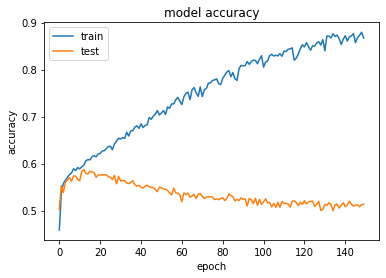

<-------------Model Loss Graph------------->


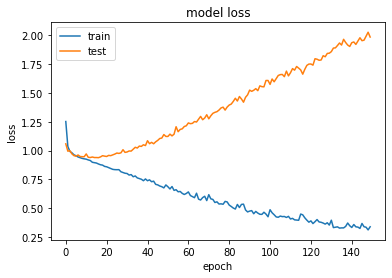

Wall time: 206 ms


In [27]:
%%time
print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history5)

print('<-------------Model Loss Graph------------->')
plot_model_loss(history5)

In [28]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback5.logs)))

Total time taken in training the model: 22.40 seconds
Wall time: 0 ns


193/193 [==============================] - 0s 499us/step - loss: 1.9820 - accuracy: 0.5135

Test accuracy = 0.5135003328323364 
loss - 1.981969952583313


Classification Report
               precision    recall  f1-score   support

           0       0.52      0.57      0.54       432
           1       0.31      0.31      0.31       523
           2       0.28      0.18      0.22       645
           3       0.43      0.39      0.41      1887
           4       0.63      0.71      0.67      2661

    accuracy                           0.51      6148
   macro avg       0.43      0.43      0.43      6148
weighted avg       0.50      0.51      0.50      6148


Confusion Matrix Display


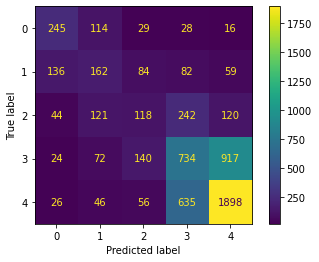

Wall time: 449 ms


In [29]:
%%time
loss5, acc5 = model5.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc5, loss5))
y_pred5 = np.argmax(model5.predict(X_test), axis=-1)
cm5 = classification_report(inverse_transformed_y_test, y_pred5)
print('\nClassification Report\n', cm5)
print('=====================================================\n')
confusion_matrix5 = confusion_matrix(inverse_transformed_y_test, y_pred5)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix5, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [30]:
%%time
q1_model_comparision.append(['Model-2', loss5, acc5])

Wall time: 0 ns


In [31]:
%%time
# ================================
# Classification report
#================================
calculate_total_correct_incorrect_prediction(confusion_matrix5)

Wall time: 1.03 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,245,56.71%,187,43.29%
1,2,162,30.98%,361,69.02%
2,3,118,18.29%,527,81.71%
3,4,734,38.9%,1153,61.1%
4,5,1898,71.33%,763,28.67%


In [32]:
%%time
# ================================
# Best and Worst performing class
#================================
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")

Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
Wall time: 0 ns


In [33]:
#==============================================================================
# Two most incorrectly classified records for each class in the test dataset.
#==============================================================================

# for i in range(1,6):  
#     count =0
#     for index, input, prediction, label in zip(enumerate(X_test), X_test, y_pred4, inverse_transformed_y_test):
#         print(index, input, prediction, label)
#         if prediction != label and count<10:
#             print(', has been classified as', prediction, 'and should be', label) 
#             count=count+1

### Model 3 (Change dropout)
#### 1. Model Building
The model is build with sequential model having 3 hidden layers. Having 128 nodes in first hidden layer, 64 nodes in second hidden layer and 64 in the third layer. We noticed that the model was training well with the less number of the nodes since we have a good amount of data. Hence with many Experimental configuration, this was one which was giving the top results.

In [34]:
%%time
# Create a new keras sequential model and add hidden layers to it with appropriate number of nodes and activation function
model6 = keras.Sequential(name = 'Model-5')
model6.add(layers.InputLayer(input_shape=(128,)))

model6.add(layers.Dense(128, activation='relu'))
# Dropout is a regularization technique and used for preventing overfitting.For the current model it works best when added to
# the 1st dense layer by preventing all neurons in a first layer from synchronously optimizing their weights.
model6.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.3))
model6.add(layers.Dense(64, activation='relu'))

model6.add(layers.Dense(5, activation='softmax'))

# Summarize the model with the different layers and the number of parameter each layer contains. It also summarize the total
# number of params in which how many are trainable and how many are non trainable. 
model6.summary()

Model: "Model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
Wall time: 25.9 ms


#### 2. Model Compilation

In [35]:
%%time
model6.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

Wall time: 4.99 ms


#### 3. Model Training

In [36]:
%%time
callback6 = TimingCallback()
history6 = model6.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback6])

Epoch 1/150
57/57 [==============================] - 1s 6ms/step - loss: 1.2965 - accuracy: 0.4521 - val_loss: 1.0847 - val_accuracy: 0.5063
Epoch 2/150
57/57 [==============================] - 0s 3ms/step - loss: 1.0279 - accuracy: 0.5467 - val_loss: 0.9921 - val_accuracy: 0.5599
Epoch 3/150
57/57 [==============================] - 0s 3ms/step - loss: 0.9860 - accuracy: 0.5648 - val_loss: 0.9711 - val_accuracy: 0.5698
Epoch 4/150
57/57 [==============================] - 0s 3ms/step - loss: 0.9643 - accuracy: 0.5735 - val_loss: 0.9856 - val_accuracy: 0.5517
Epoch 5/150
57/57 [==============================] - 0s 3ms/step - loss: 0.9594 - accuracy: 0.5687 - val_loss: 0.9493 - val_accuracy: 0.5810
Epoch 6/150
57/57 [==============================] - 0s 2ms/step - loss: 0.9446 - accuracy: 0.5824 - val_loss: 0.9445 - val_accuracy: 0.5792
Epoch 7/150
57/57 [==============================] - 0s 2ms/step - loss: 0.9353 - accuracy: 0.5869 - val_loss: 0.9476 - val_accuracy: 0.5768
Epoch 8/150
5

57/57 [==============================] - 0s 3ms/step - loss: 0.5537 - accuracy: 0.7713 - val_loss: 1.4201 - val_accuracy: 0.5159
Epoch 59/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7639 - val_loss: 1.3993 - val_accuracy: 0.5198
Epoch 60/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5368 - accuracy: 0.7749 - val_loss: 1.4328 - val_accuracy: 0.5119
Epoch 61/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.7805 - val_loss: 1.4296 - val_accuracy: 0.5078
Epoch 62/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5358 - accuracy: 0.7767 - val_loss: 1.5719 - val_accuracy: 0.4676
Epoch 63/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5315 - accuracy: 0.7784 - val_loss: 1.5097 - val_accuracy: 0.5237
Epoch 64/150
57/57 [==============================] - 0s 2ms/step - loss: 0.5070 - accuracy: 0.7920 - val_loss: 1.5433 - val_accuracy: 0.5140
Epoch 65/150
57/57 

Epoch 116/150
57/57 [==============================] - 0s 2ms/step - loss: 0.2048 - accuracy: 0.9267 - val_loss: 3.1553 - val_accuracy: 0.4732
Epoch 117/150
57/57 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.9390 - val_loss: 3.2010 - val_accuracy: 0.4867
Epoch 118/150
57/57 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9363 - val_loss: 3.2412 - val_accuracy: 0.4844
Epoch 119/150
57/57 [==============================] - 0s 1ms/step - loss: 0.1615 - accuracy: 0.9483 - val_loss: 3.2429 - val_accuracy: 0.4798
Epoch 120/150
57/57 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9333 - val_loss: 3.3248 - val_accuracy: 0.4842
Epoch 121/150
57/57 [==============================] - 0s 1ms/step - loss: 0.1373 - accuracy: 0.9616 - val_loss: 3.4019 - val_accuracy: 0.4832
Epoch 122/150
57/57 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.9647 - val_loss: 3.4561 - val_accuracy: 0.4932

<-------------Model Accuracy Graph------------->


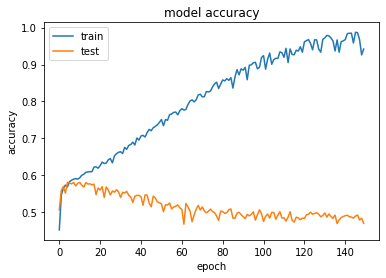

<-------------Model Loss Graph------------->


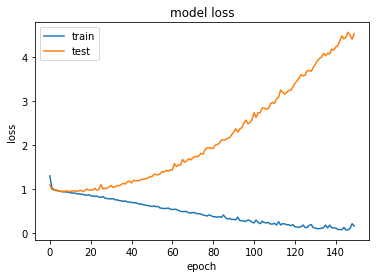

Wall time: 218 ms


In [37]:
%%time
print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history6)

print('<-------------Model Loss Graph------------->')
plot_model_loss(history6)

In [38]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback6.logs)))

Total time taken in training the model: 17.34 seconds
Wall time: 0 ns


193/193 [==============================] - 0s 933us/step - loss: 4.5377 - accuracy: 0.4699

Test accuracy = 0.4699089229106903 
loss - 4.537723064422607


Classification Report
               precision    recall  f1-score   support

           0       0.54      0.53      0.54       432
           1       0.31      0.39      0.35       523
           2       0.22      0.31      0.26       645
           3       0.40      0.37      0.38      1887
           4       0.65      0.59      0.62      2661

    accuracy                           0.47      6148
   macro avg       0.42      0.44      0.43      6148
weighted avg       0.49      0.47      0.48      6148


Confusion Matrix Display


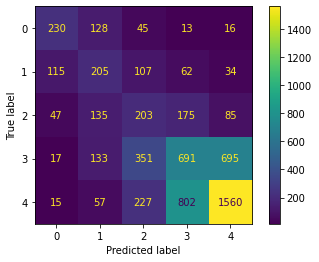

Wall time: 834 ms


In [39]:
%%time
loss6, acc6 = model6.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc6, loss6))
y_pred6 = np.argmax(model6.predict(X_test), axis=-1)
cm6 = classification_report(inverse_transformed_y_test, y_pred6)
print('\nClassification Report\n', cm6)
print('=====================================================\n')
confusion_matrix6 = confusion_matrix(inverse_transformed_y_test, y_pred6)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix6, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [40]:
%%time
q1_model_comparision.append(['Model-3', loss6, acc6])

Wall time: 0 ns


In [41]:
%%time
calculate_total_correct_incorrect_prediction(confusion_matrix6)

Wall time: 2.02 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,230,53.24%,202,46.76%
1,2,205,39.2%,318,60.8%
2,3,203,31.47%,442,68.53%
3,4,691,36.62%,1196,63.38%
4,5,1560,58.62%,1101,41.38%


In [42]:
%%time
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")

Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
Wall time: 0 ns


In [43]:
#==============================================================================
# Two most incorrectly classified records for each class in the test dataset.
#==============================================================================

# for i in range(1,6):  
#     count =0
#     for index, input, prediction, label in zip(enumerate(X_test), X_test, y_pred4, inverse_transformed_y_test):
#         print(index, input, prediction, label)
#         if prediction != label and count<10:
#             print(', has been classified as', prediction, 'and should be', label) 
#             count=count+1

***********************************
## Models Comparision
    1. Accuracy comparision of the Models
    2. Loss comparision of the Models

***********************************

In [44]:
%%time
q1_model_comparision_df = pd.DataFrame(q1_model_comparision, columns = ['Model', 'Loss', 'Accuracy'])

Wall time: 1.02 ms


Wall time: 38.9 ms


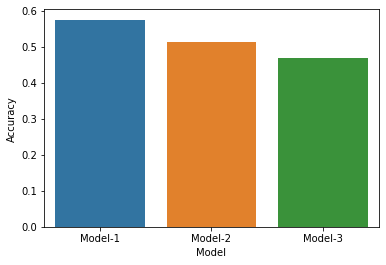

In [45]:
%%time
model2 = sns.barplot(x = 'Model', y = 'Accuracy', data = q1_model_comparision_df)

As from the Accuracy comparision bar plot, we can conclude that the Model-2 is outperforming the Model-1 in terms of the Accuracy on the Validation data.

Wall time: 37.9 ms


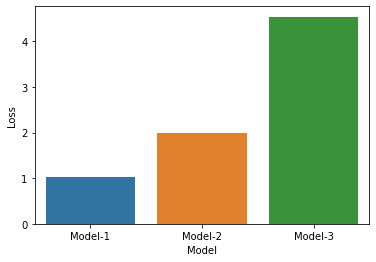

In [46]:
%%time
model1 = sns.barplot(x = 'Model', y = 'Loss', data = q1_model_comparision_df)